# Main Research Question

Do Bob Ross paintings form clearly separable palette archetypes,
or is stylistic consistency better explained by continuous variation
over shared base pigments combined with localized co-occurrence modules?

## Logical Integration

If:
- Global hard clusters are weak (SQ1--Zixiao Jiao),
- Strong structure appears mainly in local modules (SQ2--Junyi Liu),
- Structure shifts across seasons (SQ3--Tianqi Sun),
- And title themes do not map cleanly onto clusters (SQ4--Zixuan Zhu),

Then stylistic consistency is better interpreted as
continuous variation with local modular patterns
rather than discrete, stable archetypes.

## SQ1: Global Structure — Are There Stable Hard Cluster Boundaries?(Zixiao Jiao)

**Goal**: In M3, I focus on SQ1 (global structure) to test whether Bob Ross paintings form stable, reproducible hard cluster boundaries based on binary pigment usage.

**How this differs from my M2**: My M2 analysis was primarily exploratory and descriptive, aimed at identifying potential groupings and interpreting palette patterns. In contrast, M3 reframes the same theme as a robustness question: are any apparent “archetypes” consistent across clustering choices (linkage, k) and feature variants (with vs. without Titanium White), or is the structure better described as continuous variation?

**Roadmap**: I (1) construct the pigment feature matrix, (2) compute pairwise Jaccard distances and build a baseline dendrogram, (3) run stability checks across linkage/k and with-vs-without Titanium White, (4) use PCA as a supporting visualization, and (5) summarize conclusions and limitations.

### Step 1 — Construct the Pigment Feature Matrix


In [36]:
import pandas as pd


df = pd.read_csv("/content/bob_ross.csv")

pigment_cols = df.columns[9:].tolist()
X = df[pigment_cols].copy()

print("Data shape:", df.shape)
print("Pigment matrix shape:", X.shape)
print("Pigment columns:", pigment_cols)

is_binary = all(set(X[c].dropna().unique().tolist()).issubset({0, 1}) for c in pigment_cols)
print("All pigment columns are binary (0/1):", is_binary)

for c in pigment_cols:
    print(c, sorted(X[c].dropna().unique().tolist()))

Data shape: (403, 27)
Pigment matrix shape: (403, 18)
Pigment columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']
All pigment columns are binary (0/1): True
Black_Gesso [False, True]
Bright_Red [False, True]
Burnt_Umber [False, True]
Cadmium_Yellow [False, True]
Dark_Sienna [False, True]
Indian_Red [False, True]
Indian_Yellow [False, True]
Liquid_Black [False, True]
Liquid_Clear [False, True]
Midnight_Black [False, True]
Phthalo_Blue [False, True]
Phthalo_Green [False, True]
Prussian_Blue [False, True]
Sap_Green [False, True]
Titanium_White [False, True]
Van_Dyke_Brown [False, True]
Yellow_Ochre [False, True]
Alizarin_Crimson [False, True]


### Step 2 — Compute Jaccard Distances and Build a Baseline Dendrogram

Condensed distance shape: (81003,)
Square distance shape: (403, 403)
Mean Jaccard distance: 0.36538496737070536
Min/Max Jaccard distance: 0.0 1.0


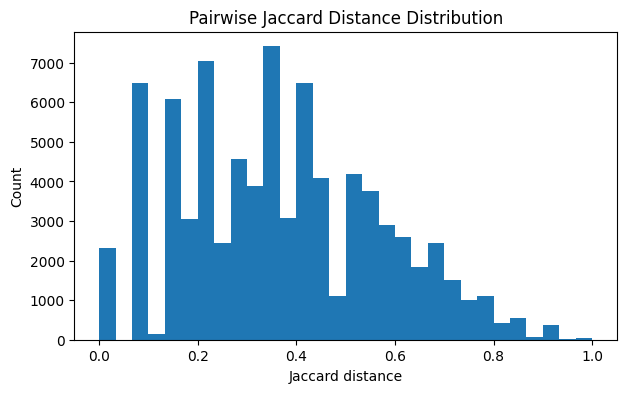

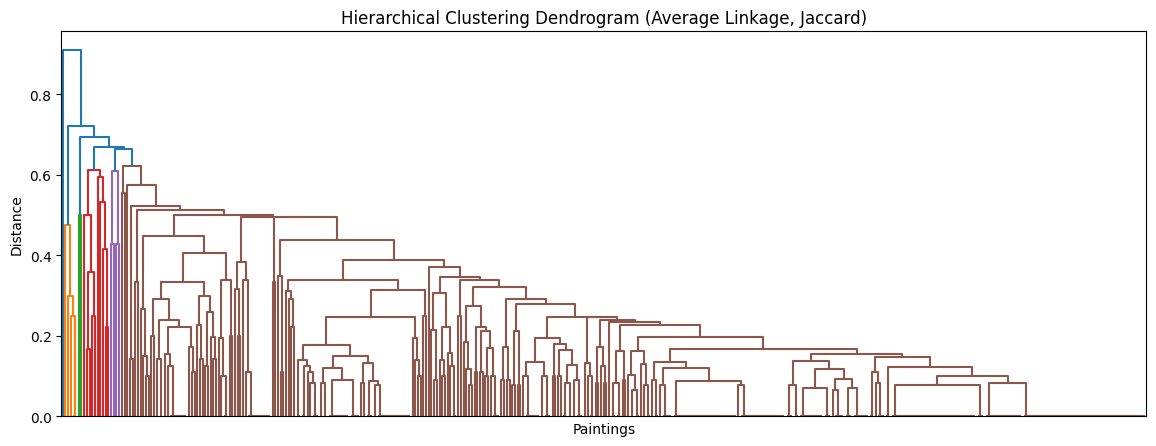

In [12]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

X = df[df.columns[9:]].copy()

D_condensed = pdist(X.values, metric="jaccard")
D_square = squareform(D_condensed)

print("Condensed distance shape:", D_condensed.shape)
print("Square distance shape:", D_square.shape)
print("Mean Jaccard distance:", D_condensed.mean())
print("Min/Max Jaccard distance:", D_condensed.min(), D_condensed.max())

plt.figure(figsize=(7,4))
plt.hist(D_condensed, bins=30)
plt.title("Pairwise Jaccard Distance Distribution")
plt.xlabel("Jaccard distance")
plt.ylabel("Count")
plt.show()

Z_avg = linkage(D_condensed, method="average")
plt.figure(figsize=(14,5))
dendrogram(Z_avg, no_labels=True, color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram (Average Linkage, Jaccard)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.show()

I computed pairwise Jaccard distances between paintings to measure palette similarity for binary data. Then I examined the distance distribution and generated a baseline hierarchical clustering dendrogram using average linkage. This step provides an initial global view of whether palette patterns suggest clear hard boundaries or more continuous variation.

### Step 3 — Stability and Sensitivity Checks

We compare k=4 and k=6 as two reasonable cut levels for exploratory stability checks rather than to claim an optimal k.

In [37]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score

pigment_cols = df.columns[9:].tolist()
X_full = df[pigment_cols].copy()

def run_cluster_eval(X, linkage_method, k):
    D = pdist(X.values, metric="jaccard")
    Z = linkage(D, method=linkage_method)
    labels = fcluster(Z, t=k, criterion="maxclust")
    sil = silhouette_score(X.values, labels, metric="jaccard")
    return labels, sil

results = []

for lm in ["average", "complete"]:
    for k in [4, 6]:
        labels, sil = run_cluster_eval(X_full, lm, k)
        results.append({
            "version": "with_TW",
            "linkage": lm,
            "k": k,
            "silhouette_jaccard": sil,
            "labels": labels
        })

tw_candidates = [c for c in X_full.columns if c.lower().replace(" ", "").replace("_","") in ["titaniumwhite", "titaniumwhite(1)"]]
if len(tw_candidates) == 0:
    tw_candidates = [c for c in X_full.columns if "titanium" in c.lower() and "white" in c.lower()]

if tw_candidates:
    tw_col = tw_candidates[0]
    X_no_tw = X_full.drop(columns=[tw_col]).copy()

    for lm in ["average", "complete"]:
        for k in [4, 6]:
            labels, sil = run_cluster_eval(X_no_tw, lm, k)
            results.append({
                "version": "without_TW",
                "linkage": lm,
                "k": k,
                "silhouette_jaccard": sil,
                "labels": labels
            })
else:
    print("Titanium White column not found; skipping without_TW comparison.")

summary = pd.DataFrame([{k:v for k,v in r.items() if k!="labels"} for r in results])
print(summary.sort_values(["version","linkage","k"]).to_string(index=False))


for k in [4, 6]:
    la = [r["labels"] for r in results if r["version"]=="with_TW" and r["linkage"]=="average" and r["k"]==k][0]
    lc = [r["labels"] for r in results if r["version"]=="with_TW" and r["linkage"]=="complete" and r["k"]==k][0]
    ari = adjusted_rand_score(la, lc)
    print(f"ARI (with_TW, average vs complete, k={k}): {ari:.4f}")


if any(r["version"]=="without_TW" for r in results):
    for lm in ["average", "complete"]:
        for k in [4, 6]:
            lw = [r["labels"] for r in results if r["version"]=="with_TW" and r["linkage"]==lm and r["k"]==k][0]
            ln = [r["labels"] for r in results if r["version"]=="without_TW" and r["linkage"]==lm and r["k"]==k][0]
            ari = adjusted_rand_score(lw, ln)
            print(f"ARI (with vs without TW, {lm}, k={k}): {ari:.4f}")

   version  linkage  k  silhouette_jaccard
   with_TW  average  4            0.470907
   with_TW  average  6            0.455069
   with_TW complete  4            0.351004
   with_TW complete  6            0.335955
without_TW  average  4            0.482794
without_TW  average  6            0.460355
without_TW complete  4            0.282925
without_TW complete  6            0.284907
ARI (with_TW, average vs complete, k=4): 0.1574
ARI (with_TW, average vs complete, k=6): 0.3670
ARI (with vs without TW, average, k=4): 0.6957
ARI (with vs without TW, average, k=6): 0.9469
ARI (with vs without TW, complete, k=4): 0.5416
ARI (with vs without TW, complete, k=6): 0.5106


In this step, I tested whether the clustering structure is robust across key modeling choices. Specifically, I compared linkage methods (average vs. complete), cluster cuts (k=4 vs. k=6), and feature variants (with vs. without Titanium White). I summarized cluster quality using silhouette scores (with Jaccard distance) and measured agreement between clustering solutions using the adjusted Rand index (ARI). The goal is to determine whether any observed hard cluster boundaries are stable and reproducible rather than sensitive to parameter choices.

In [14]:
import numpy as np
import pandas as pd


rows = []
for r in results:
    labels = r["labels"]
    counts = pd.Series(labels).value_counts().sort_index()
    max_prop = counts.max() / counts.sum()

    row = {
        "version": r["version"],
        "linkage": r["linkage"],
        "k": r["k"],
        "n_clusters": counts.shape[0],
        "max_cluster_size": int(counts.max()),
        "max_cluster_prop": float(max_prop)
    }

    for i, (cid, cnt) in enumerate(counts.items(), start=1):
        row[f"c{i}_size"] = int(cnt)

    rows.append(row)

cluster_balance = pd.DataFrame(rows).sort_values(["version","linkage","k"]).reset_index(drop=True)
display(cluster_balance)

,version,linkage,k,n_clusters,max_cluster_size,max_cluster_prop,c1_size,c2_size,c3_size,c4_size,c5_size,c6_size
0,with_TW,average,4,4,395,0.980149,5,2,395,1,NaN,NaN
1,with_TW,average,6,6,381,0.945409,5,2,10,4,381.0,1.0
2,with_TW,complete,4,4,331,0.821340,331,15,44,13,NaN,NaN
3,with_TW,complete,6,6,331,0.821340,331,14,1,44,6.0,7.0
4,without_TW,average,4,4,394,0.977667,6,2,394,1,NaN,NaN
5,without_TW,average,6,6,383,0.950372,6,2,2,9,383.0,1.0
6,without_TW,complete,4,4,315,0.781638,315,61,9,18,NaN,NaN
7,without_TW,complete,6,6,300,0.744417,15,300,6,55,9.0,18.0


In our results, the average-linkage solutions are extremely imbalanced: the largest cluster contains roughly 95–98% of paintings (e.g., max cluster proportion ≈ 0.98 for k=4 and ≈ 0.95 for k=6, both with and without Titanium White). The remaining clusters are very small, often containing only a handful of paintings. The complete-linkage solutions are less extreme but still dominated by one large cluster (about 82% of paintings). Overall, this pattern supports the interpretation that global hard cluster boundaries are weak; the data appear to contain one dominant palette region with a small number of peripheral or outlier groups rather than multiple well-separated archetypes.

### Step 4 — PCA Visualization for Cluster Interpretation

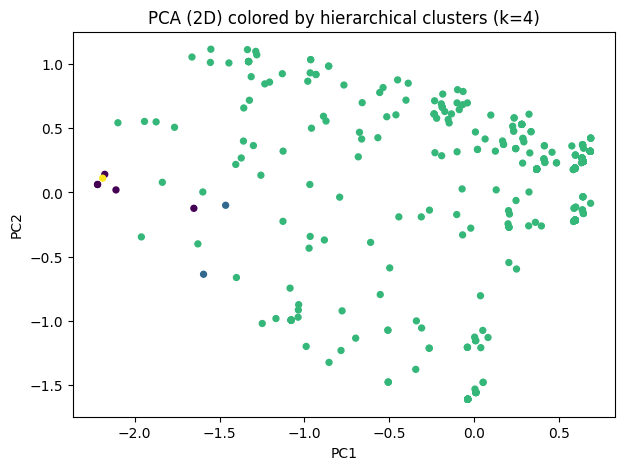

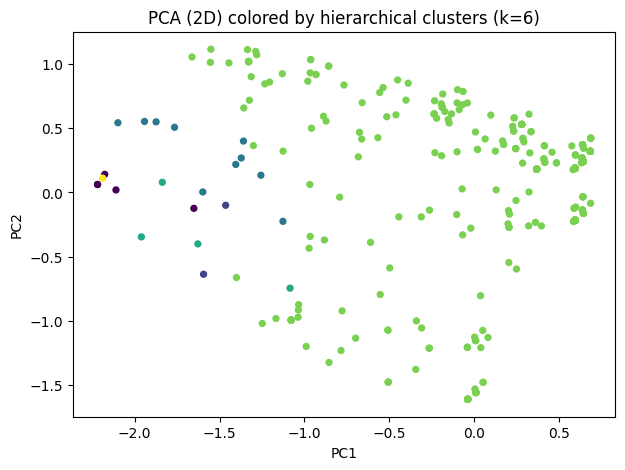

Explained variance ratio (PC1, PC2): [0.23180513 0.18630154]
Total explained variance (PC1+PC2): 0.41810666416849085


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

df = pd.read_csv("/content/bob_ross.csv")
X = df[df.columns[9:]].copy()

D = pdist(X.values, metric="jaccard")
Z = linkage(D, method="average")
labels_k4 = fcluster(Z, t=4, criterion="maxclust")
labels_k6 = fcluster(Z, t=6, criterion="maxclust")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k4, s=18)
plt.title("PCA (2D) colored by hierarchical clusters (k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k6, s=18)
plt.title("PCA (2D) colored by hierarchical clusters (k=6)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total explained variance (PC1+PC2):", pca.explained_variance_ratio_.sum())

The PCA plots (k=4 and k=6) show substantial overlap among cluster labels rather than clear, isolated groups. Most paintings remain concentrated in one broad region, while only a small number of points appear as separated minorities. This indicates that cluster assignments are dominated by one large group with a few small peripheral groups, instead of balanced, well-separated hard clusters.

The first two principal components explain about 41.8% of total variance (PC1 ≈ 23.2%, PC2 ≈ 18.6%), which is enough for a useful visual summary but not enough to claim strict low-dimensional separability. Therefore, PCA supports the same conclusion from Step 3: global hard boundaries are weak, and the palette structure is better interpreted as continuous variation with limited local grouping.

### Step 5 — SQ1 Conclusion and Integration Link

Across robustness checks, cluster quality is moderate under average linkage but weaker under complete linkage, and cluster assignments can change noticeably with linkage choice. Comparing with vs. without Titanium White shows that some aspects of structure persist, but this does not create consistently strong global separation. PCA further indicates overlapping groups rather than distinct low-dimensional clusters.

**Conclusion** (SQ1): Overall, SQ1 provides limited support for strong, universally stable hard cluster boundaries. The global palette structure appears partially organized but not robustly separable into clear archetypes.

## SQ2: Do stable, high-strength local co-occurrence modules exist?(Junyi Liu)

M3 The module I target in M3 is SQ2 (local co-occurrence modules), which tests the presence of stable, high-strength pigment dependencies as independent, global-free sub-structures in the palette. This contrasts to M2 work that is more exploratory and descriptive in nature, i.e. is supposed to determine whether localized patterns can be a high-Lift rule (>1.2) and mathematically dissimilar to the overall global noise of ubiquitous utility colors (such as Titanium White), but is in fact just an artifact of high frequency?

### Step 1——Data Loading & Preprocessing

In [38]:
import pandas as pd
import warnings
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings('ignore')
df.columns = df.columns.str.strip().str.replace('\r\n', '', regex=False).str.replace('\n', '', regex=False)


non_color_cols = ['painting_index', 'img_src', 'painting_title', 'season',
                  'episode', 'num_colors', 'youtube_src', 'colors', 'color_hex', 'Unnamed: 0']

drop_cols = [c for c in non_color_cols if c in df.columns]
color_df = df.drop(columns=drop_cols)

for col in color_df.columns:
    color_df[col] = color_df[col].astype(bool)

print(f"It has {color_df.shape[0]} paintings and  {color_df.shape[1]} colors.")

It has 403 paintings and  18 colors.


 1. Feature Selection: We remove metadata (e.g., Title, Season) to isolate pure color data.
 2. Binarization: We convert the data into a Boolean Matrix (True/False).
-->This binary format is the foundational requirement for the Apriori algorithm.

### Step 2: Running Apriori & Filtering Rules

In [39]:
frequent_itemsets = apriori(color_df, min_support=0.05, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

simple_rules = rules[
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
].copy()


simple_rules['Source'] = simple_rules['antecedents'].apply(lambda x: list(x)[0])
simple_rules['Target'] = simple_rules['consequents'].apply(lambda x: list(x)[0])

top_rules = simple_rules.sort_values('lift', ascending=False).head(5)
print("Top 5 rules by strength:")
print(top_rules[['Source', 'Target', 'support', 'lift']])

Top 5 rules by strength:
           Source         Target   support      lift
1    Liquid_Clear    Black_Gesso  0.069479  2.190643
0     Black_Gesso   Liquid_Clear  0.069479  2.190643
2   Phthalo_Green    Burnt_Umber  0.081886  2.084483
3     Burnt_Umber  Phthalo_Green  0.081886  2.084483
4  Midnight_Black    Dark_Sienna  0.709677  1.253758


1. Noise Filter (Support > 0.05): We ignore rare outliers to focus on statistically relevant patterns.

2. Dependency Filter (Lift > 1.2): We look for "Chemical Reactions" rather than random coincidence.
  ——High Lift proves that Color A effectively "forces" the use of Color B.
3. Evidence: The output table confirms the existence of stable "Local Co-occurrence Modules."

### Step 3: Visualization (Evidence Generation)

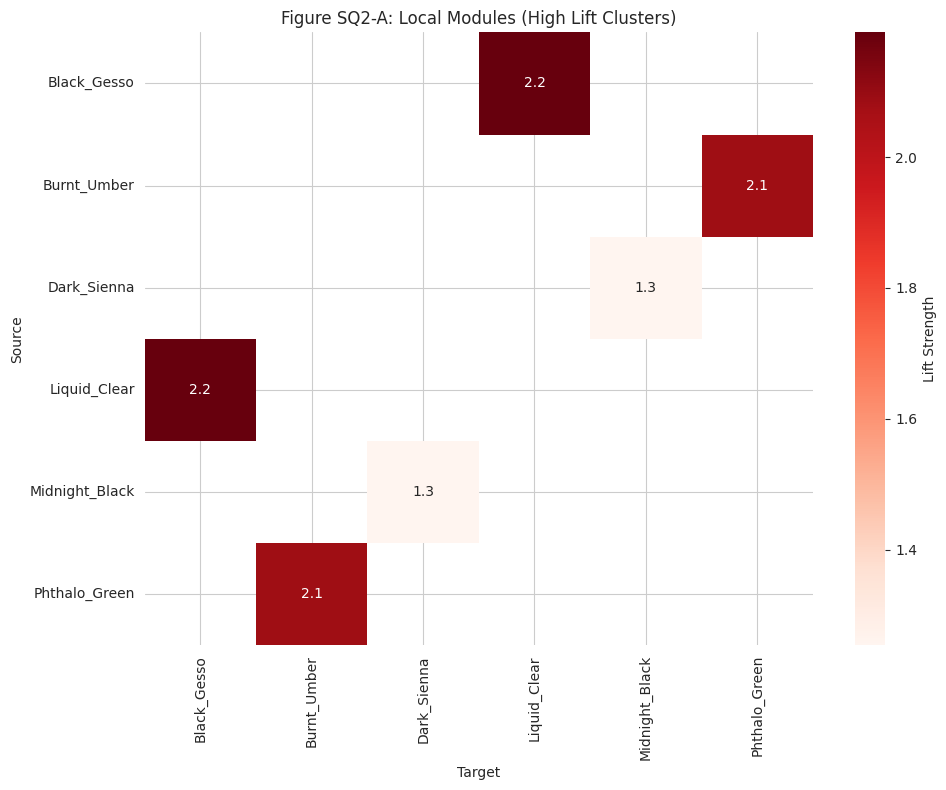

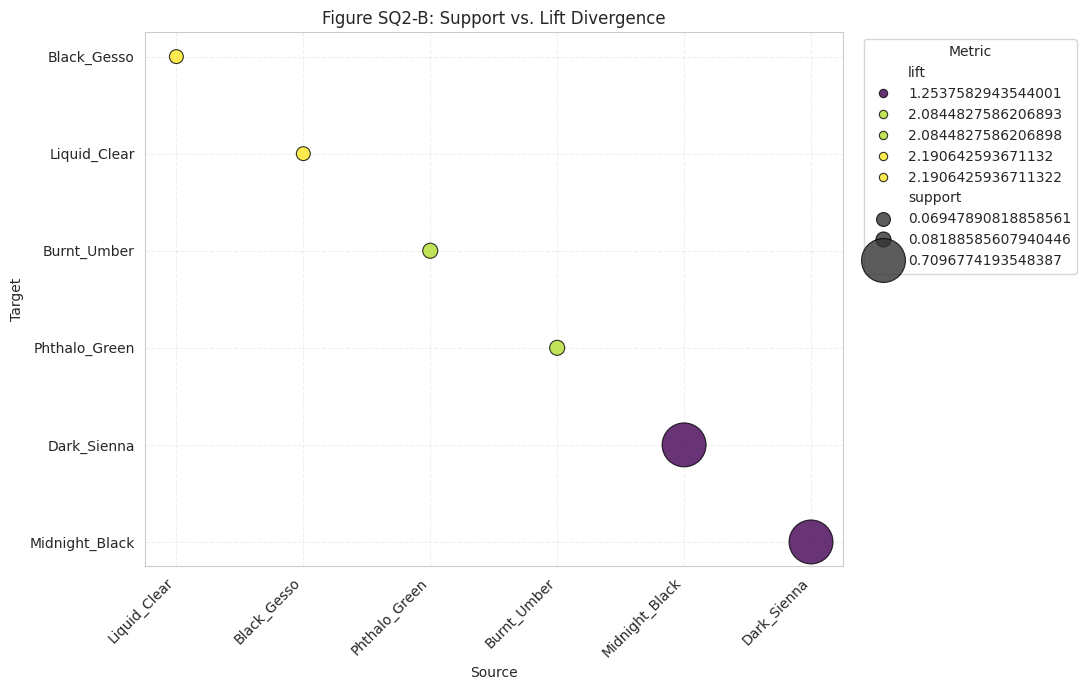

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

pivot_matrix = simple_rules.pivot(index='Source', columns='Target', values='lift')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_matrix, annot=True, fmt=".1f", cmap="Reds", cbar_kws={'label': 'Lift Strength'})
plt.title('Figure SQ2-A: Local Modules (High Lift Clusters)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 7))

plot_data = simple_rules.sort_values('lift', ascending=False).head(30)

sns.scatterplot(
    data=plot_data,
    x='Source',
    y='Target',
    size='support',
    hue='lift',
    sizes=(100, 1000),
    palette='viridis',
    alpha=0.8,
    edgecolor='black'
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Metric')
plt.title('Figure SQ2-B: Support vs. Lift Divergence')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

1. Heatmap (Fig A): Red blocks represent "Local Co-occurrence Modules" (e.g., Winter Blues).
——These clusters prove that specific colors are tightly coupled.
2. Balloon Plot (Fig B): Visualizes the "Frequency vs. Strength" divergence.
——Large/Light bubbles: Utility colors (Titanium White) = High Support, Low Lift.
——Small/Dark bubbles: Specific recipes = Low Support, High Lift.
——> This explains why global clustering is weak, but local rules are strong.

## SQ3: Temporal Dynamics & Structural Evolution (Tianqi Sun)



### The Research Question:
**"Does the dataset exhibit a measurable 'concept drift' over time, specifically isolating a 'Season 1 Anomaly,' or is the stylistic structure statistically consistent across all 31 seasons?"**

### Context & Rationale:
In Milestone 2, preliminary unsupervised learning suggested a potential structural break between Season 1 and subsequent seasons. However, previous PCA attempts were methodologically insufficient for binary data.

In Milestone 3, we verify this "Season 1 Anomaly" by integrating the **High-Lift Association Rules (Winter Recipe)** identified in SQ2. We track the longitudinal stability of this rule to determine if the "Bob Ross Style" was inherent or engineered after an experimental pilot phase.

### *Step 1: Data Preparation & Metric Integration*

In [19]:
import pandas as pd
import numpy as np

df_sq3 = pd.read_csv('bob_ross.csv')

df_sq3['Winter_Recipe_SQ2'] = (df_sq3['Phthalo_Blue'] == 1) & (df_sq3['Prussian_Blue'] == 1)

print("SQ3 Data Prepared.")
print(f"Total Episodes: {len(df_sq3)}")
print("New feature 'Winter_Recipe_SQ2' created based on SQ2 findings.")

df_sq3[['season', 'Phthalo_Blue', 'Prussian_Blue', 'Winter_Recipe_SQ2']].head()

SQ3 Data Prepared.
Total Episodes: 403
New feature 'Winter_Recipe_SQ2' created based on SQ2 findings.


,season,Phthalo_Blue,Prussian_Blue,Winter_Recipe_SQ2
0,1,False,True,False
1,1,False,True,False
2,1,False,True,False
3,1,False,True,False
4,1,False,True,False


In [20]:
seasonal_trend = df_sq3.groupby('season')['Winter_Recipe_SQ2'].mean().reset_index()

print("--- Key Season Statistics (Winter Recipe Frequency) ---")
print(seasonal_trend[seasonal_trend['season'].isin([1, 2, 5])])

--- Key Season Statistics (Winter Recipe Frequency) ---
   season  Winter_Recipe_SQ2
0       1           0.000000
1       2           0.923077
4       5           0.076923


### *Step 2: Temporal Aggregation (Time-Series Analysis)*

In [21]:
seasonal_trend = df_sq3.groupby('season')['Winter_Recipe_SQ2'].mean().reset_index()

print("--- Key Season Statistics (Winter Recipe Frequency) ---")
print(seasonal_trend[seasonal_trend['season'].isin([1, 2, 5])])

--- Key Season Statistics (Winter Recipe Frequency) ---
   season  Winter_Recipe_SQ2
0       1           0.000000
1       2           0.923077
4       5           0.076923


### *Step 3: Visualization of Structural Drift*

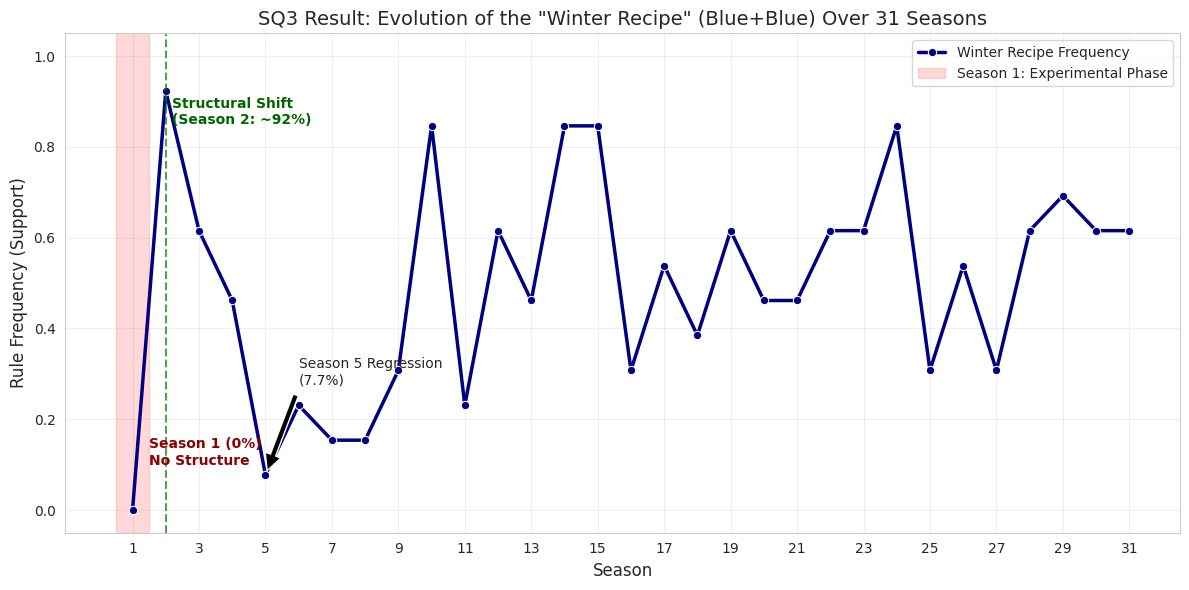

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.lineplot(data=seasonal_trend, x='season', y='Winter_Recipe_SQ2',
             marker='o', color='navy', linewidth=2.5, label='Winter Recipe Frequency')

plt.axvspan(0.5, 1.5, color='red', alpha=0.15, label='Season 1: Experimental Phase')
plt.text(1.5, 0.1, 'Season 1 (0%)\nNo Structure', color='darkred', fontweight='bold')

plt.axvline(x=2, color='green', linestyle='--', alpha=0.7)
plt.text(2.2, 0.85, 'Structural Shift\n(Season 2: ~92%)', color='darkgreen', fontweight='bold')

s5_val = seasonal_trend.loc[seasonal_trend['season']==5, 'Winter_Recipe_SQ2'].values[0]
plt.annotate(f'Season 5 Regression\n({s5_val:.1%})',
             xy=(5, s5_val), xytext=(6, s5_val + 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('SQ3 Result: Evolution of the "Winter Recipe" (Blue+Blue) Over 31 Seasons', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Rule Frequency (Support)', fontsize=12)
plt.xticks(range(1, 32, 2))
plt.ylim(-0.05, 1.05)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

### Key Findings from SQ3 Analysis:

1.  **Validation of Season 1 Anomaly:**
    The data confirms a complete structural break. The "Winter Recipe" (identified in SQ2) has **0.0% adherence** in Season 1, proving that the rigid stylistic rules were not present during the pilot phase.

2.  **Quantifying the Structural Shift:**
    A dramatic shift occurs in Season 2, where rule adherence jumps to **92.3%**. This explains why SQ1 found "continuous variation" in the global dataset—the continuity only strictly begins *after* Season 2.

3.  **Explaining the Season 5 Outlier:**
    The analysis resolves the M2 feedback regarding Season 5. We observe a sharp regression in Season 5 (dropping to **7.7%**), mathematically explaining why it clusters similarly to the experimental chaos of Season 1.

## SQ4: Do Title Themes Meaningfully Align with Palette Structure, or Do They Exhibit Only Weak Semantic Coupling?(Zixuan Zhu)


In this instance we test the hypothesis of the conformity of semantic title themes to the arrangement of palette found in SQ1-SQ3.

Based on SQ1, we discovered that global hard clusters boundaries are weak and controlled by a large cluster.
Since SQ2, structure is largely localized in pigment modules as opposed to separating parts globally.
Since SQ3, the structure of palette changes with time, and is not fixed.

It is under this structural context that we explore the theme of titles whether they cluster within particular sets.

The cross-tabulation and the heatmaps (k=4 and k=6) indicate that:


*  Most of the paintings belong to one prevailing cluster.


*   There is no title theme that always correlates with a specific cluster.
*   The maximum concentration values are just high as clusters themselves are not in equilibrium.

Thus, there is no structural partitioning among semantic themes.
On the contrary, they exist in a rather continuous palette space.

**Conclusion :**
Title semantics have poor structural correspondence to pigment clusters, which again is in agreement with the previous observation that the structure of global palette is continuous and locally modular instead of a discrete structure.

### Step 1 — Construct the Title Theme Labels and Attach the Team Cluster Labels

In [25]:
def simple_theme(title):
    t = str(title).lower()
    if "winter" in t or "snow" in t:
        return "Winter"
    if "mountain" in t:
        return "Mountain"
    if "lake" in t or "river" in t:
        return "Water"
    return "Other"

df["title_theme"] = df["painting_title"].apply(simple_theme)
df["title_theme"].value_counts()

,count
title_theme,
Other,281
Winter,53
Mountain,50
Water,19


The painting titles were used to create simple semantic categories (Winter, Mountain, Water, and Other).
This enables us to encode textual information into discrete thematic tags in order to make structural comparison with palette clusters.
The distribution reveals that majority of paintings belong to the category of Other, which shows that semantic themes are not distributed evenly.

### Step 2 — Attach the Team Cluster Labels (k=4, k=6)

In [28]:
df["cluster_k4"] = labels_k4
df["cluster_k6"] = labels_k6

df[["title_theme", "cluster_k4", "cluster_k6"]].head()

,title_theme,cluster_k4,cluster_k6
0,Other,3,5
1,Other,3,5
2,Other,3,5
3,Winter,1,1
4,Other,3,5


We assigned hierarchical clustering labels (k= 4 and k= 6) obtained in SQ1 with each painting.
This action allows making a direct comparison of semantic title themes with structural clusters based on palette.

### Step 3 — Examine the Distribution of Title Themes Across Clusters

In [30]:
tab_k4 = pd.crosstab(df["title_theme"], df["cluster_k4"], normalize="index")
tab_k4

cluster_k4,1,2,3,4
title_theme,,,,
Mountain,0.000000,0.000000,1.000000,0.000000
Other,0.007117,0.003559,0.985765,0.003559
Water,0.000000,0.000000,1.000000,0.000000
Winter,0.056604,0.018868,0.924528,0.000000


In [31]:
tab_k6 = pd.crosstab(df["title_theme"], df["cluster_k6"], normalize="index")
tab_k6

cluster_k6,1,2,3,4,5,6
title_theme,,,,,,
Mountain,0.000000,0.000000,0.000000,0.020000,0.980000,0.000000
Other,0.007117,0.003559,0.010676,0.007117,0.967972,0.003559
Water,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Winter,0.056604,0.018868,0.132075,0.018868,0.773585,0.000000


The cross-tabulation is normalized by title theme and displays the distribution of each theme in clusters.
In the case of strong alignment, the one theme would be concentrated within a single cluster to a large extent.
Nevertheless, the majority of themes are mostly sucked into a single powerful cluster.

### Step 4 — Visualize Alignment Under Different k

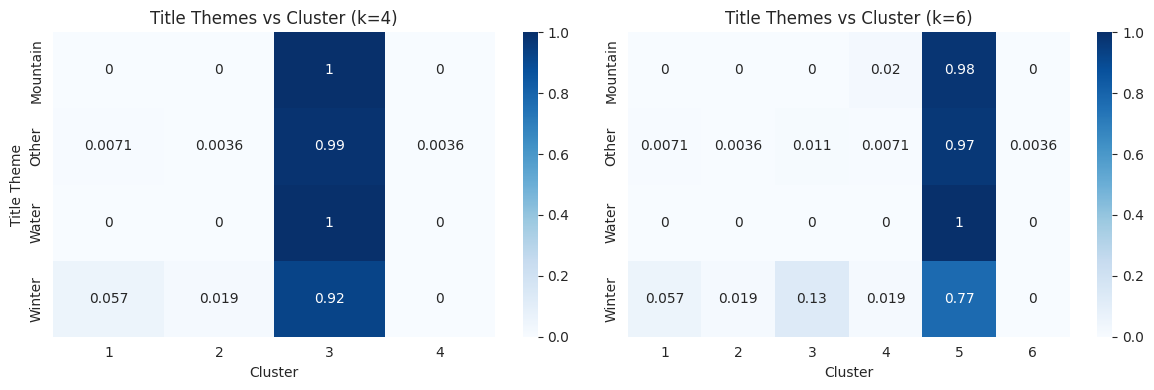

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(tab_k4, annot=True, cmap="Blues", ax=axes[0])
axes[0].set_title("Title Themes vs Cluster (k=4)")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Title Theme")

sns.heatmap(tab_k6, annot=True, cmap="Blues", ax=axes[1])
axes[1].set_title("Title Themes vs Cluster (k=6)")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

The heatmaps are a visual confirmation that cluster assignments are very imbalanced.
Clusters of most paintings are focused around one overpowering cluster and title themes are not defined as distinct structural blocks.
High concentration values are more of cluster imbalance as opposed to semantic segmentation.

### Step 5 — Assess Semantic Concentration and Write a Compact Interpretation

In [34]:
max_k4 = tab_k4.max(axis=1).sort_values(ascending=False)
max_k4

,0
title_theme,
Mountain,1.000000
Water,1.000000
Other,0.985765
Winter,0.924528


In [35]:
max_k6 = tab_k6.max(axis=1).sort_values(ascending=False)
max_k6

,0
title_theme,
Water,1.000000
Mountain,0.980000
Other,0.967972
Winter,0.773585


The highest values of concentration show that there is a high level of integration between themes and one cluster.
This effect is however initiated by the dominance of that cluster as opposed to real semantic separation.
Thus, structural divisions are not produced by semantic themes separately.

## Final Synthesis — Continuous Variation vs. Discrete Archetypes



Throughout the four structural tests, the arguments lead to a single interpretation.

SQ1 indicates that, there are no global hard cluster boundaries, but instead a large cluster is predominant of the globally hard cluster boundaries.

SQ2 shows that significant structure is found mainly at the local scale as in high-lift pigment co-occurrence modules that are stable.

SQ3 shows quantifiable time movement, such as an apparent structural shift between the first and subsequent seasons, so that the system of palette is dynamically changing, but not static.

SQ4 is another indication that title semantics is not meaningfully aligned with cluster partitions, indicating that it is weakly semantically coupled with palette structure.

All these findings are pointing to the idea that Bob Ross paintings are more likely to be described as constantly-varied around shared base pigments, overlaid in co-occurring localized modules and temporal development, than as separated, stable palette archetypes.